In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)
    xgb.fit(X_train, y_train)

    return xgb

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)
    dnn.fit(X_train, y_train)

    return dnn

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)
    knn.fit(X_train, y_train)

    return knn

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [1]:
noise_intervals = [20, 60, 120, 300, 600]
noise_lengths = [3, 5, 7, 15]
noise_means = [1, 3, 5, 7, 12]

A_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_XGB = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

A_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_DNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

A_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GP_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GR_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])
GF1_KNN = np.zeros([len(noise_intervals),len(noise_lengths),len(noise_means)])

def training_loop(noise_lengths, noise_intervals, noise_means):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    spacing = 1
    w_length = 10
    sampling = 1
    
    for i, n_interval in enumerate(noise_intervals): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, n_length in enumerate(noise_lengths): #enumerate(range(minlength,maxlength+1,steplength)):
            for m, n_mean in enumerate(noise_means):
                print('********************************')
                print('Iteration for spacing={}; window length={}; noise interval={}; noise length={}; noise mean={}'.format(spacing, w_length, n_interval, n_length, n_mean))

                ####### 1) Load dataset #######
                print('1) Loading dataset into (XX,yy)...')

                XX = None
                yy = None
                folderpath='../Features_1_3'

                for filename in os.listdir(folderpath):
                    if filename.endswith('_nm' + str(noise_mean) + '_ni' + str(noise_interval) + '_nl' + str(noise_length) 
                                         + '_sa' + str(sampling) + '_sp' + str(spacing) + '_w' + str(w_length) + '.dat'):
                        label = 0
                        if int(filename[9]) > 5:
                            label = 1
                        fullname = folderpath + '/' + filename
                        XX, yy = load_window_dataset(XX, yy, fullname, label)

                scaler = StandardScaler()
                XX = scaler.fit_transform(XX)

                X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
                print('Training XGB...')
                xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

                print('Training DNN...')
                dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

                print('Training KNN...')
                knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

                xgb_all_ttimes.append(xgb_ttimes)
                dnn_all_ttimes.append(dnn_ttimes)
                knn_all_ttimes.append(knn_ttimes)

                y_pred_XGB = xgb.predict(X_test)
                y_pred_DNN = dnn.predict(X_test)
                y_pred_KNN = knn.predict(X_test)

                A_XGB[i,j,m], GP_XGB[i,j,m], GR_XGB[i,j,m], GF1_XGB[i,j,m] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
                A_DNN[i,j,m], GP_DNN[i,j,m], GR_DNN[i,j,m], GF1_DNN[i,j,m] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
                A_KNN[i,j,m], GP_KNN[i,j,m], GR_KNN[i,j,m], GF1_KNN[i,j,m] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

NameError: name 'np' is not defined

In [9]:
fig_folder = '1_3_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(noise_lengths, noise_intervals, noise_means)

********************************
Iteration for spacing=3 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
3.0132546424865723
2.8171379566192627
2.8641154766082764
Training DNN...
37.83703279495239
33.49836182594299
43.92972159385681
Training KNN...
0.1478731632232666
0.12687182426452637
0.15343284606933594
********************************
Iteration for spacing=3 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
2.9580166339874268
2.945356845855713
3.0555331707000732
Training DNN...
30.735480546951294
37.14926600456238
29.92574644088745
Training KNN...
0.20226430892944336
0.15001583099365234
0.1503007411956787
********************************
Iteration for spacing=3 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
2.756493091583252
2.8078324794769287
2.8214666843414307
Training DNN...
29.80427622795105
37.95539474487305
28.040963172912598
Training KNN...
0.1593918800354004
0.13913512229919434
0.13183999061584473
*********

27.95125150680542
22.995704412460327
23.622626543045044
Training KNN...
0.03643155097961426
0.03704094886779785
0.0436253547668457
********************************
Iteration for spacing=10 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.37737131118774414
0.44638705253601074
0.45043087005615234
Training DNN...
21.655827045440674
23.24738335609436
23.535515785217285
Training KNN...
0.03499412536621094
0.05054879188537598
0.03777456283569336
********************************
Iteration for spacing=10 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.3431892395019531
0.35237717628479004
0.37746453285217285
Training DNN...
10.94467830657959
13.093385219573975
8.69340705871582
Training KNN...
0.03980207443237305
0.03870701789855957
0.03656268119812012
********************************
Iteration for spacing=10 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.32608819007873535
0.34679675102233887
0.3444240093231201
Traini

Training XGB...
0.08793902397155762
0.09688878059387207
0.10374617576599121
Training DNN...
1.7503063678741455
1.7778851985931396
1.6645753383636475
Training KNN...
0.007002353668212891
0.006145000457763672
0.005990028381347656
********************************
Iteration for spacing=75 and window length=300
1) Loading dataset into (XX,yy)...
Training XGB...
0.10989046096801758
0.11268925666809082
0.11175894737243652
Training DNN...
1.114487886428833
1.1860733032226562
1.06410551071167
Training KNN...
0.004999399185180664
0.004000425338745117
0.004002094268798828
********************************
Iteration for spacing=75 and window length=750
1) Loading dataset into (XX,yy)...
Training XGB...
0.07751965522766113
0.09415245056152344
0.09665560722351074
Training DNN...
0.9316518306732178
0.8998610973358154
0.9195291996002197
Training KNN...
0.004000663757324219
0.003997325897216797
0.0029993057250976562
********************************
Iteration for spacing=75 and window length=1200
1) Load

Training XGB...
0.06408047676086426
0.07202625274658203
0.07200193405151367
Training DNN...
0.5280117988586426
0.43505167961120605
0.49771571159362793
Training KNN...
0.0019989013671875
0.0020012855529785156
0.0029973983764648438
********************************
Iteration for spacing=300 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
0.059007883071899414
0.06903815269470215
0.07090473175048828
Training DNN...
0.4762701988220215
0.41133761405944824
0.466963529586792
Training KNN...
0.0019986629486083984
0.0010046958923339844
0.001998424530029297
********************************
Iteration for spacing=300 and window length=3600
1) Loading dataset into (XX,yy)...
Training XGB...
0.056420087814331055
0.06599903106689453
0.06674480438232422
Training DNN...
0.41205835342407227
0.3957843780517578
0.3876228332519531
Training KNN...
0.002027750015258789
0.001978158950805664
0.0009961128234863281
********************************
Iteration for spacing=750 and window leng

0.3173377513885498
0.35349297523498535
0.2517547607421875
Training KNN...
0.0
0.0
0.0
********************************
Iteration for spacing=1800 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
0.0460810661315918
0.05980277061462402
0.06332278251647949
Training DNN...
0.45869898796081543
0.5487067699432373
0.4949493408203125
Training KNN...
0.0
0.0
0.015633821487426758
********************************
Iteration for spacing=1800 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.04766702651977539
0.061995506286621094
0.06288886070251465
Training DNN...
0.5790679454803467
0.54850172996521
0.4907419681549072
Training KNN...
0.0
0.0
0.0
********************************
Iteration for spacing=1800 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
0.04556465148925781
0.056150197982788086
0.05858421325683594
Training DNN...
0.26274609565734863
0.24436593055725098
0.22034788131713867
Training KNN...
0.0010957717895507812
0.00100

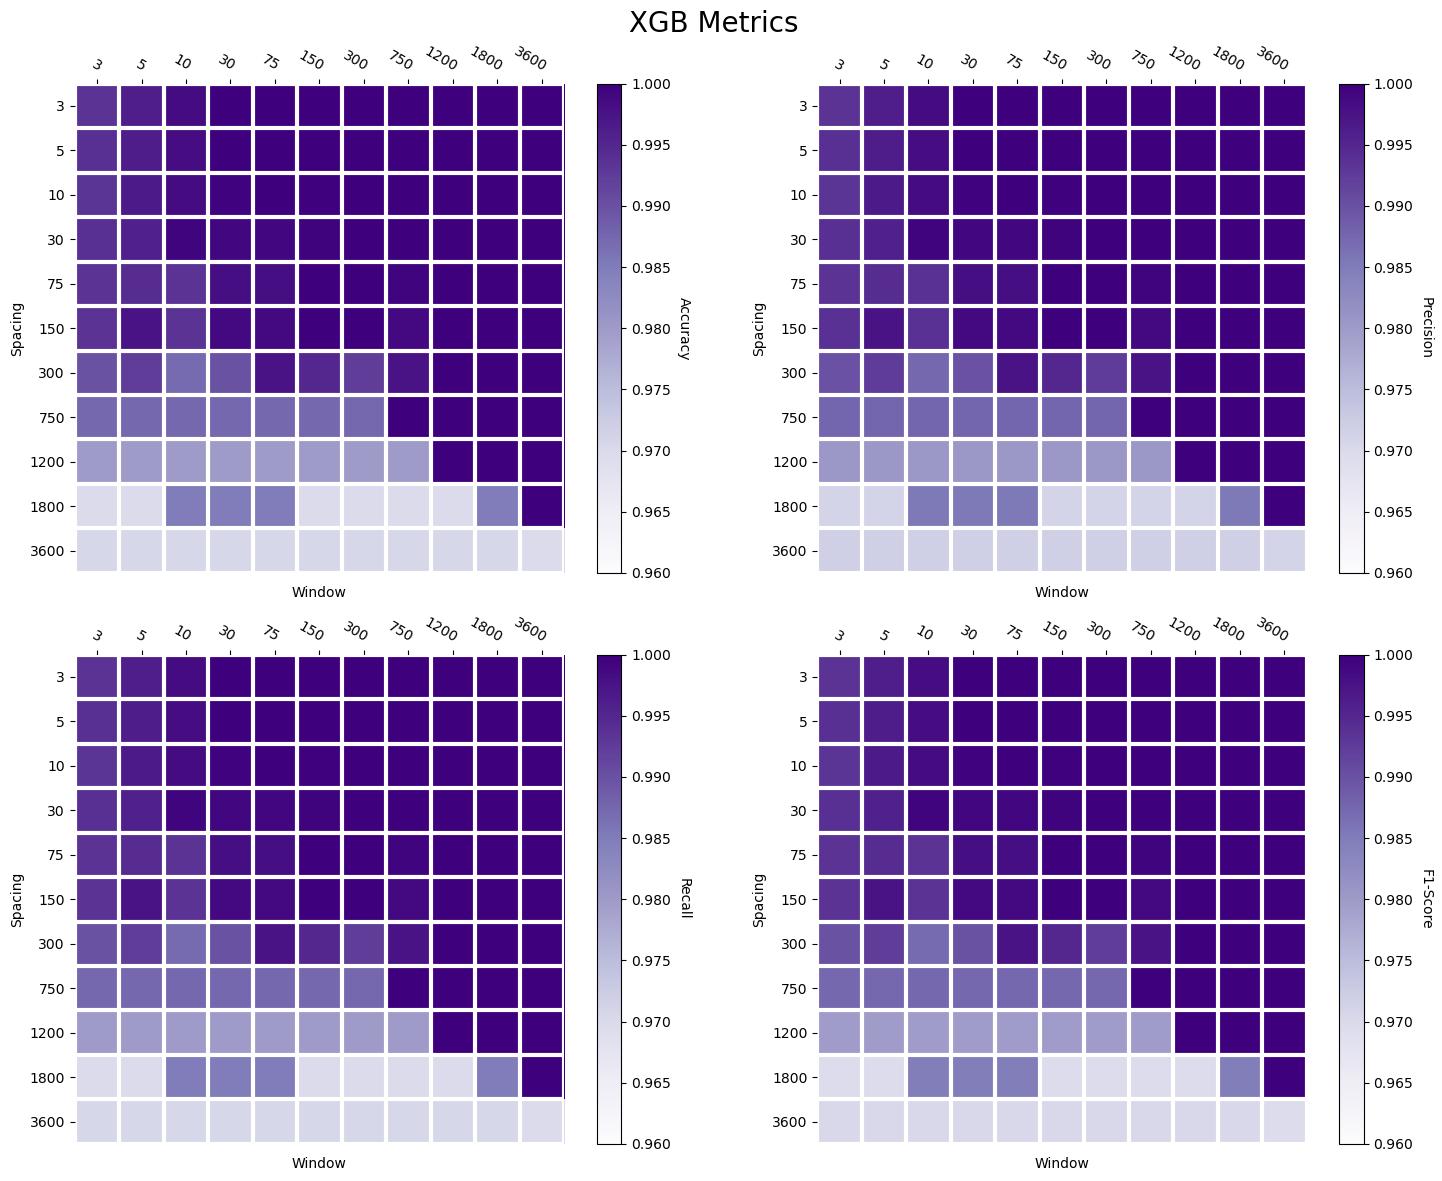

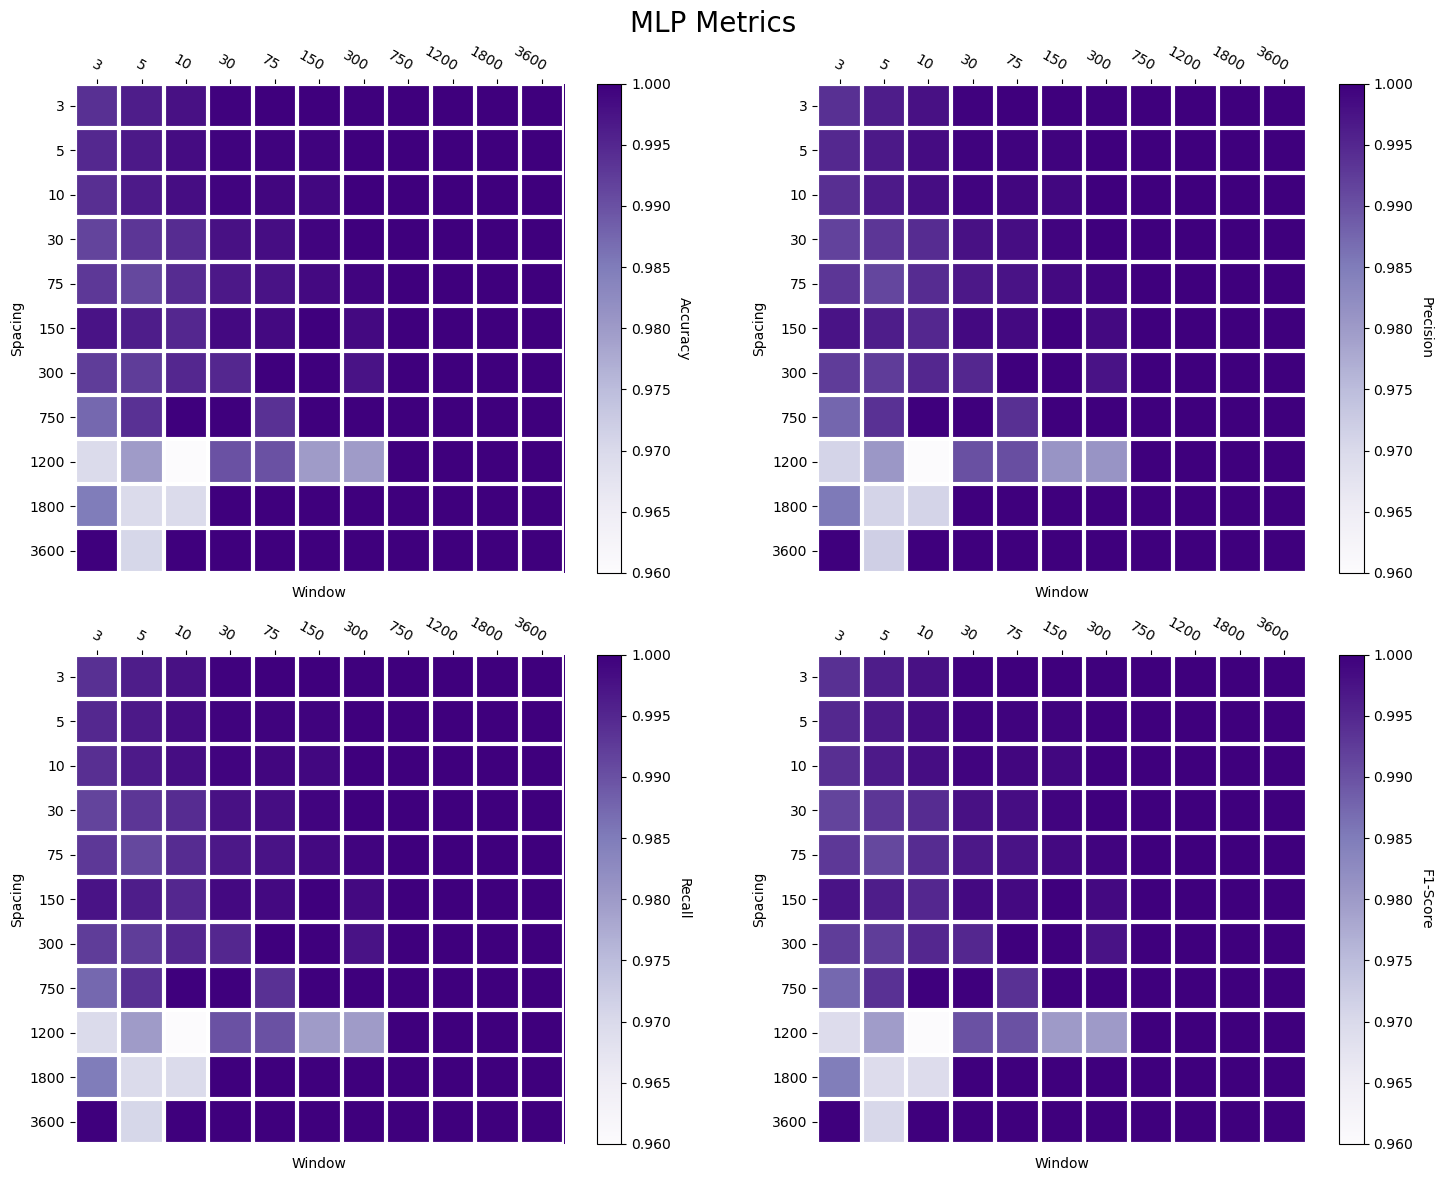

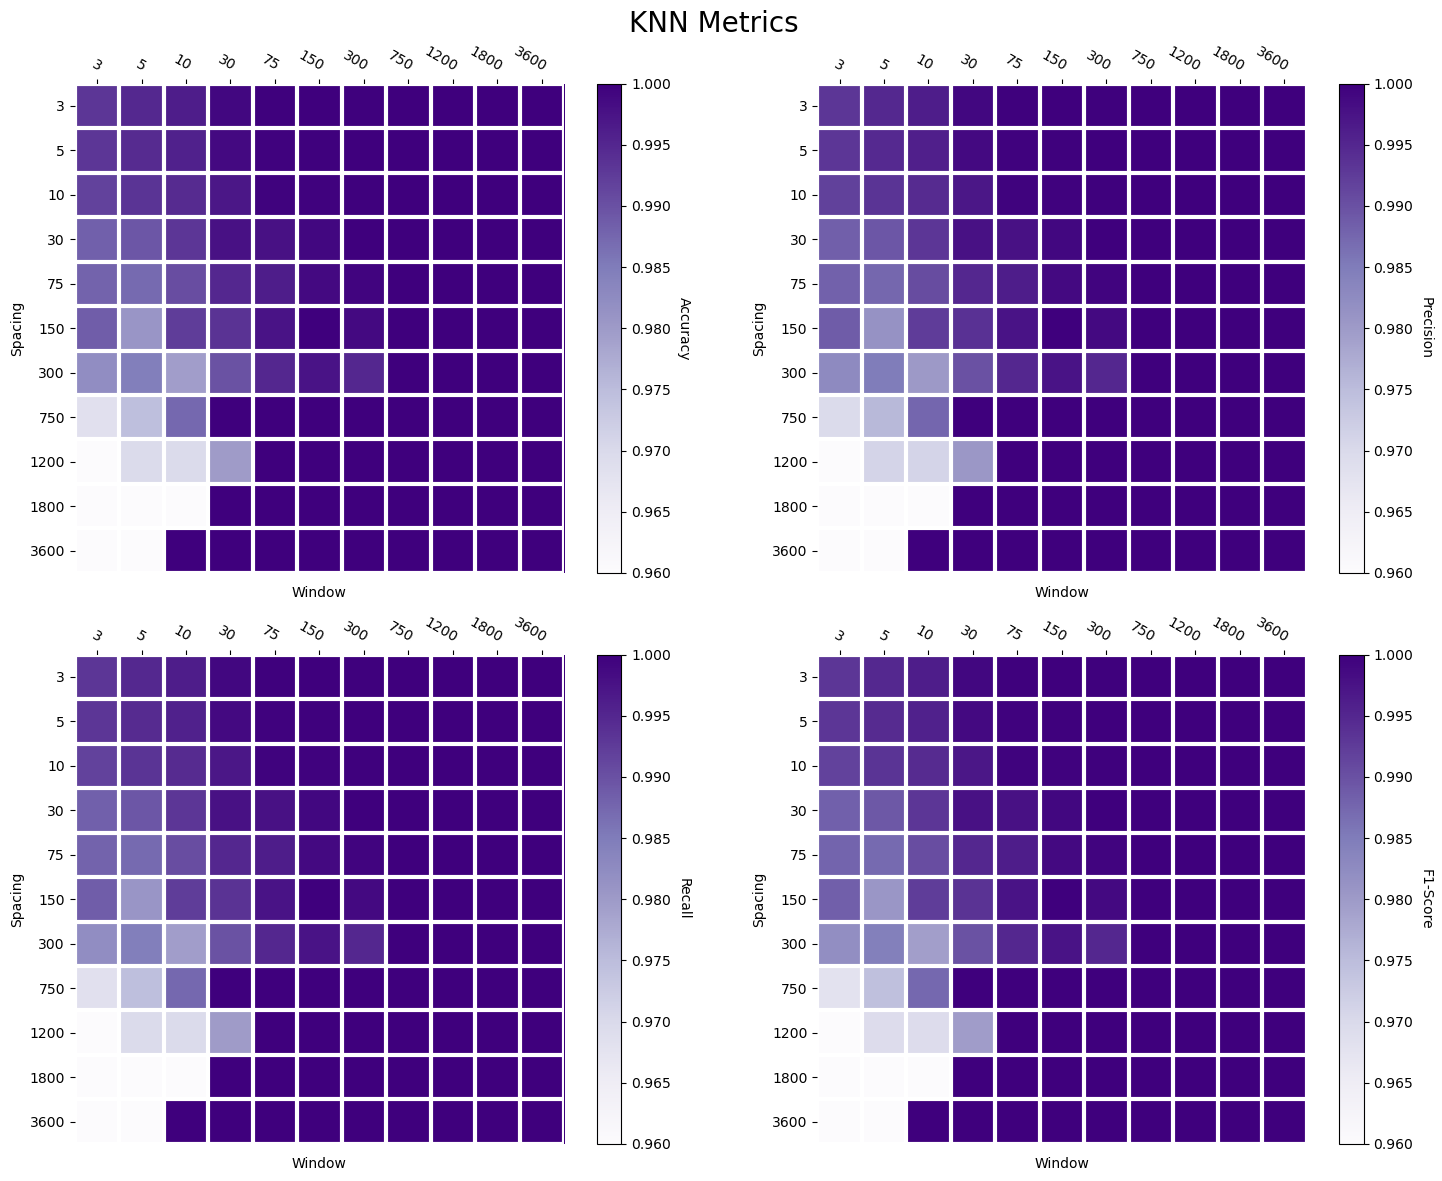

In [11]:
str_window_range = [str(x) for x in noise_lengths]
str_spacing_range = [str(x) for x in noise_intervals]

alg_names = ['XGB', 'MLP', 'KNN']

A_mat = [A_XGB, A_DNN, A_KNN]
GP_mat = [GP_XGB, GP_DNN, GP_KNN]
GR_mat = [GR_XGB, GR_DNN, GR_KNN]
GF1_mat = [GF1_XGB, GF1_DNN, GF1_KNN]

for i in range(0, 3):
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))

    im, _ = heatmap(A_mat[i], str_spacing_range, str_window_range, ax=ax,
                    cmap="Purples", cbarlabel="Accuracy", vmin=0.96, vmax=1)

    im, _ = heatmap(GP_mat[i], str_spacing_range, str_window_range, ax=ax2,
                    cmap="Purples", cbarlabel="Precision", vmin=0.96, vmax=1)

    im, _ = heatmap(GR_mat[i], str_spacing_range, str_window_range, ax=ax3,
                    cmap="Purples", cbarlabel="Recall", vmin=0.96, vmax=1)

    im, _ = heatmap(GF1_mat[i], str_spacing_range, str_window_range, ax=ax4,
                    cmap="Purples", cbarlabel="F1-Score", vmin=0.96, vmax=1)

    title = alg_names[i] + " Metrics"
    fig.suptitle(title, fontsize=20)
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')
    plt.tight_layout()
    plt.show()